# Make me an Image Analyst already!

In the last lesson you learnt the basics of Python. You learnt what variables are, how loops function and how to get a list of our filenames. In this lesson we will learn how to read and display images, followed by how to identify objects of interest in the image. 

Since the information we generated in the other notebook can't be shared with this notebook, let's regenerate our file list of images. We didn't mention in the last lesson that it is customary to put all the import statements at the top of a program, although this isn't a requirement it helps to keep the code organized. 

In [5]:
import os
import glob
root_root = '/home/aneesh/Images/Source/'
dir_of_root = os.listdir(root_root)

file_paths = [glob.glob(os.path.join(root_root,dor, '*.tif')) for dor in dir_of_root]
print(file_paths[0][0])

'/home/aneesh/Images/Source/Type1/Type1_15.tif'

# Reading Images

In the last cell we printed the name of the first image file in the Type1 directory. We will use this as our test file for now. 

To read images anaconda comes with the sci-kit image package, which has many useful functions for image analysis. Among them are the functions `imread()` and `imshow()` these readn and display the image respectively. As with os and glob the scikit image package has to be imported, but in this case we won't be using many functions from the package so we will only import the imread() and imshow() functions. 

you will notice a strange looking line: `%matplotlib inline` this is actually meant for the jupyter notebook. This tells the notebook to display the images within the page. 

/home/aneesh/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


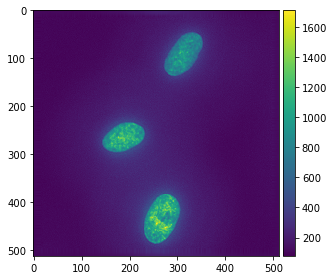

In [7]:
from skimage.io import imread, imshow
%matplotlib inline
in_img = imread(file_paths[0][0])
imshow(in_img)

If you open the corresponding image in Fiji you will see that its displayed in grayscale, while here it looks blue-green. This is because the imshow() function applies something called as a lookup table (LUT) to help our eyes see the high and low intensities better. If you would like to still view it as a grey image we can change the display parameters as below:

/home/aneesh/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


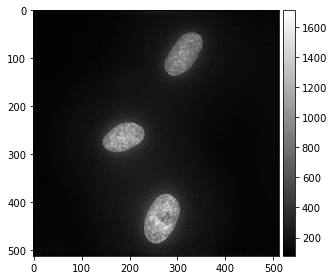

In [9]:
import matplotlib.cm as cm
imshow(in_img, cmap=cm.gray)

Above, matplotlib is the standard plotting library in python. Matplotlib has a function called as colormap which corresponds to the `cm` that we import. We tell imshow to use the `cm.gray` colormap to display our image in grayscale. You can also use other colormaps, go ahead and experiment if you wish.

# Now that I have the Image, what do i do?

Congrats! You have successfully read and displayed an image! If you are from a bio-background you will identify the little gray blobs as nuclei of cells. For those of you not from a bio-background nuclei is where cells store their DNA. We acquired these images on a microscope by applying a fluorescent dye specific to the DNA and capturing the image with a microscope.

Surely this isn't enough. We would like to measure things about the nucleus. Many things can be measured, but for the purposes of this exercise we will lmit ourselves to measuring the area and the length of the major axis. 

But.. we are jumping ahead. Although we can see the nuclei, the computer doesn't know what you are talking about all it sees is numbers. Don't believe me?
try printing the variable that hold our image:

In [16]:
in_img

array([[116, 117, 116, ..., 117, 116, 117],
       [117, 117, 117, ..., 117, 117, 117],
       [117, 117, 117, ..., 117, 117, 117],
       ..., 
       [115, 116, 116, ..., 117, 116, 116],
       [116, 117, 116, ..., 117, 116, 116],
       [116, 117, 116, ..., 117, 117, 117]], dtype=uint16)

And, that's what an image really is. Its just a series of numbers which are interpreted by the computer and displayed as intensities, which our eyes then interpret as images. Nothing particularly fancy.

However, images being *just numbers* gives us a big advantage. We can do mathematical operations on them. In our images for example the nuclei are bright compared to the background. Maybe this can be used to tell the computer where the nuclei are?

# GIVE ME ALLLLL THE BRIGHT THINGS

How will you figure out what you count as bright? One way is to open the image in imageJ and see wha the approximate intensities of images are. We will try a little dumber method here, but learn a few things about **arrays** along the way

Like lists arrays are a kind of object in python. They are a lot more powerful than lists when it comes to manipulation but come with some drawbacks. Usually we end up using a list, an array, or something else as the situation demands. 

Arrays aren't a default part of Python, but are introduced by the Numpy package. The next line is one that you will have at the top of nearly every program you write:


In [11]:
import numpy as np

We have just imported numpy but decided to refer to it as np. You can replace 'np' with anything you like but np is the standard used everywhere, so I suggest you stick to it. This helps in things like copy-pasting code from the internet ;)

let's declare a small numpy array and play with it a little bit.

In [15]:
myarray = np.array([[1,2,3],
                  [1,2,3],
                  [1,2,3]])
myarray

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

You might notice that the object passed to the `np.array()` function is a list. The `np.array()` function takes the list and converts it to an array. You know it's an array because it says 'array' when its printed. This is the same thing that was printed when we called our image variable. So, we can safely say that our image is also an array. Anything that we do with this small array here can also be done to our bigger image array. In fact we can even treat our little array as an image and see how it looks:




/home/aneesh/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


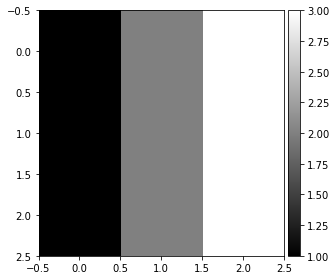

In [21]:
imshow(myarray, cmap=cm.gray)

With the image we would like to find all the pixels that are bright. In the case of our small array, we can decide that everything bigger than 1 is a bright pixel. Using this as our criteria, we can as the computer to identify the pixels for us. 

How you ask? Remember the booleans from the last lesson?


In [17]:
myarray>1

array([[False,  True,  True],
       [False,  True,  True],
       [False,  True,  True]], dtype=bool)

We get a *boolean array* which is full of true and false values corresponding to our question: is this number bigger than 1

Boolean arrays have some interesting properties, one of which is that you can multiply them with regular arrays. The True values are treated as 1 and the False as 0. However, we will not go into that right now. 

Right now we'd like to know of a good method to identify our nuclei. 

# Otsu: the man on the threshold.

In the last section when we asked the computer which values are greater than 1 what we did was set the threshold as '1'. But this isn't always straighforward especially with images where the intensities can vary a lot. This means that if you painfully find the threshold for one image there is no gurantee that it will work for the next image. What we need to do is to use the characteristics of the image to determine what the appropriate threshold is. 

Otsu's method is a very effective way of doing this. I won't go into the details of the method but I highly reccomend reading about it: https://en.wikipedia.org/wiki/Otsu%27s_method

The nice people behind the Scikit Image package have already made a function to determine the otsu threshold as shown below. This can alse be applied to our image. 

1
[[False  True  True]
 [False  True  True]
 [False  True  True]]


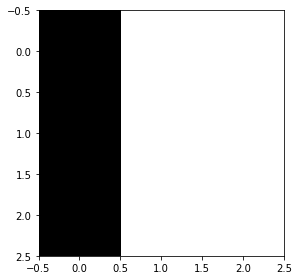

In [25]:
from skimage.filters import threshold_otsu
my_array_thresh = threshold_otsu(myarray)
print(my_array_thresh)

print(myarray>my_array_thresh)
imshow(myarray>my_array_thresh)

561


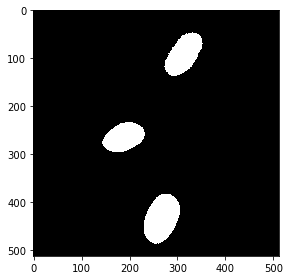

In [27]:
img_thresh = threshold_otsu(in_img)
print(img_thresh)
bw_img = in_img>img_thresh
imshow(bw_img)

Otsu's method identifies '560' as being a good threhold for our image to identify the brighter objects and it seems to do a good job!

The next step is to get the area of the first nucleus.... but which is the first nucleus??

# Tag 'em and bag 'em

How do we decide which the first nucleus to be analysed should be? There is no inherent numbering and if you look at the `bw_img` its just true/false values. One option is to number all the objects based on if they are connected to other pixels of the same value. This is called labeling. scikit image has a function for this. The `label()` function takes in a black and white image and returns an image where each object has been given a number, which is interpreted as an intensity by the imshow function. 

/home/aneesh/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


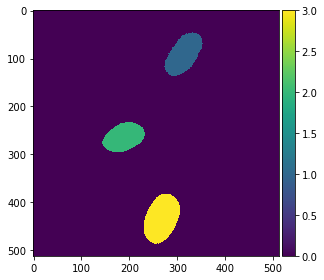

In [28]:
from skimage.measure import label
label_im = label(bw_img)
imshow(label_im)

Now we have a way to determine the order in which objects are measured. The function to measure objects is called `regionprops()`. This function takes in the labelled image and the intensity image as an input and returns an object which has measurements of each of the objects. 

In [29]:
from skimage.measure import regionprops

r_props = regionprops(label_im, in_img)

#print length of number r_props to determine number of objects measured.
len(r_props)

3

Unlike the other data types which we have seen so far regionprops gives us a list of named properties these can be accessed as below:



In [35]:
# Area for the first object
print(r_props[0].area)
# Area for the first object
print(r_props[1].area)
# Area for the first object
print(r_props[2].area)

4599
4017
5648


**Note:** Regionprops returns many properties a full list of the properties is available in the help file. The help for any imported function can be accessed by running the `help(regionprops)` command.

In [ ]:
help(regionprops)

We can also use list comprehension to collect all the measured areas into a single list.

In [37]:
all_areas = [rp.area for rp in r_props]
print(all_areas)

[4599, 4017, 5648]


So this was for the objects in a single image. As with the filenames you can imagine that we can combine the file reading, thresholding and measurement into a series of actions taken inside a loop. This is exactly what we will do in the next lesson.